In [5]:
!pip install --user xgboost

In [6]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from collections import Counter
from itertools import zip_longest

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import sklearn.metrics as metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [7]:
with open('train_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
data.head()

,ip,app,device,os,channel,day,hour,minute,second,ip_app_counts,...,ip_app_device_channel_nextClick,ip_app_os_channel_nextClick,ip_device_os_channel_nextClick,app_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,sin_click_hour,cos_click_hour,sin_click_day,cos_click_day,is_attributed
46608628,31012,2,1,18,219,1,11,43,36,-0.136522,...,1.264200e+04,1.000000e+10,1.000000e+10,73406.0,1.000000e+10,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,0
153478577,58404,2,1,19,477,3,6,17,46,-0.119743,...,6.353700e+04,1.000000e+10,1.000000e+10,38083.0,1.000000e+10,1.000000e+00,6.123234e-17,9.749279e-01,-0.222521,0
97459643,105560,12,1,19,328,2,8,47,20,1.491040,...,9.456000e+03,9.456000e+03,9.456000e+03,63151.0,9.456000e+03,7.071068e-01,-7.071068e-01,7.818315e-01,0.623490,0
122871484,50301,12,1,23,340,2,16,16,4,-0.170080,...,1.000000e+10,1.000000e+10,1.000000e+10,60215.0,1.000000e+10,-8.660254e-01,-5.000000e-01,7.818315e-01,0.623490,0
113711899,77840,18,1,46,439,2,13,37,37,-0.153301,...,1.000000e+10,1.000000e+10,1.000000e+10,58907.0,1.000000e+10,-5.000000e-01,-8.660254e-01,7.818315e-01,0.623490,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913692 entries, 46608628 to 184882311
Data columns (total 66 columns):
ip                                    913692 non-null uint32
app                                   913692 non-null uint16
device                                913692 non-null uint16
os                                    913692 non-null uint16
channel                               913692 non-null uint16
day                                   913692 non-null uint8
hour                                  913692 non-null uint8
minute                                913692 non-null uint8
second                                913692 non-null uint8
ip_app_counts                         913692 non-null float64
ip_device_counts                      913692 non-null float64
ip_os_counts                          913692 non-null float64
ip_channel_counts                     913692 non-null float64
app_device_counts                     913692 non-null float64
app_os_counts           

Dropping 'day', 'hour', 'minute', and 'second', because these features are ingrained in the transformed hour and day features.

In [10]:
data = data.drop(['day','hour','minute','second'], axis = 1)

# 1.) Splitting data into train and test set

Using stratified sampling to have an equal amount of fraudulent and non-fraudulent clicks for both the train and the test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,data.columns!='is_attributed'],
                                                    data.is_attributed,
                                                    test_size=0.3,
                                                    stratify=data.is_attributed)

# 2.) Running models without hyperparameter tuning

First, I will run the baseline models without performing parameter tuning to see how well they performe on the feature engineered dataset.

## 2.1) Logistic Regression

In [12]:
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)

In [13]:
# Train score
logit_y_pred_train = logit.predict(X_train)

# Cross-validation error
logit_cv = cross_val_score(logit, X_train, y_train, scoring = 'f1', cv = 3, n_jobs = -1)

# Test score
logit_y_pred_test = logit.predict(X_test)

Using classification report and AUC curve to evaluate performance.<br>

Classification reports:

In [14]:
print('Classification report: Train set\n', classification_report(y_train, logit_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, logit_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(logit_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       0.77      0.83      0.80    319792
       Fraud       0.81      0.75      0.78    319792

    accuracy                           0.79    639584
   macro avg       0.79      0.79      0.79    639584
weighted avg       0.79      0.79      0.79    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       0.77      0.83      0.80    137054
       Fraud       0.81      0.75      0.78    137054

    accuracy                           0.79    274108
   macro avg       0.79      0.79      0.79    274108
weighted avg       0.79      0.79      0.79    274108
 ##########################################################
Avg. f1 score: cross-validation set
 0.78


ROC-AUC curve:

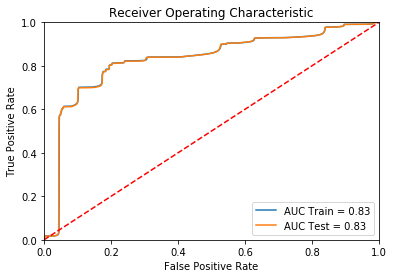

In [15]:
# Train FPR and TPR
logit_probs_train = logit.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, logit_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
logit_probs_test = logit.predict_proba(X_test)
fpr_test_logit, tpr_test_logit, threshold_test = metrics.roc_curve(y_test, logit_probs_test[:,1])
roc_auc_test_logit = metrics.auc(fpr_test_logit, tpr_test_logit)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_logit, tpr_test_logit, label = 'AUC Test = %0.2f' % roc_auc_test_logit)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

## 2.2) Random Forest Classifier

In [16]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

In [17]:
# Train score
rf_y_pred_train = rf.predict(X_train)

# Cross-validation error
rf_cv = cross_val_score(rf, X_train, y_train, scoring = 'f1', cv = 3, n_jobs = -1)

# Test score
rf_y_pred_test = rf.predict(X_test)

Classification reports:

In [18]:
print('Classification report: Train set\n', classification_report(y_train, rf_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, rf_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(rf_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    319792
       Fraud       1.00      1.00      1.00    319792

    accuracy                           1.00    639584
   macro avg       1.00      1.00      1.00    639584
weighted avg       1.00      1.00      1.00    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    137054
       Fraud       1.00      1.00      1.00    137054

    accuracy                           1.00    274108
   macro avg       1.00      1.00      1.00    274108
weighted avg       1.00      1.00      1.00    274108
 ##########################################################
Avg. f1 score: cross-validation set
 1.0


ROC-AUC curve:

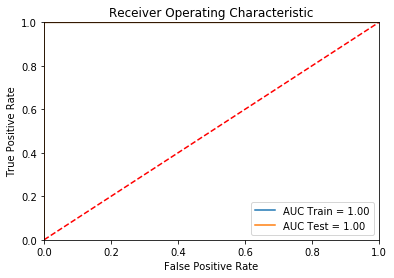

In [19]:
# Train FPR and TPR
rf_probs_train = rf.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, rf_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
rf_probs_test = rf.predict_proba(X_test)
fpr_test_rf, tpr_test_rf, threshold_test = metrics.roc_curve(y_test, rf_probs_test[:,1])
roc_auc_test_rf = metrics.auc(fpr_test_rf, tpr_test_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_rf, tpr_test_rf, label = 'AUC Test = %0.2f' % roc_auc_test_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

# 3.) Feature Importance

## 3.1.) Logistic Regression - Feature Importance

In [20]:
feature_importance_logit=pd.DataFrame(np.hstack((np.array([X_train.columns[:]]).T, logit.coef_.T)), columns=['feature', 'importance'])

In [21]:
feature_importance_logit = feature_importance_logit.sort_values(by='importance', ascending=True)

Looking only at the most important feature that are important to predict a download (positive beta coefficient)

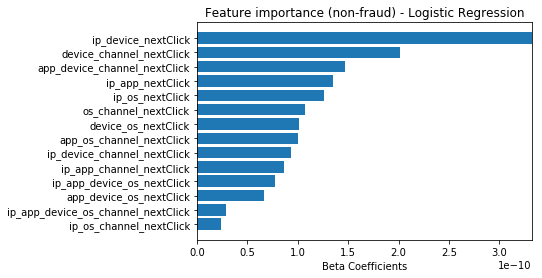

In [22]:
y_pos = np.arange(len(feature_importance_logit.feature[feature_importance_logit.importance>=0.1e-10]))

plt.barh(y_pos, feature_importance_logit.importance[feature_importance_logit.importance>=0.1e-10])
plt.yticks(y_pos, feature_importance_logit.feature[feature_importance_logit.importance>=0.1e-10])
plt.title('Feature importance (non-fraud) - Logistic Regression')
plt.xlabel('Beta Coefficients')
plt.show()

Clearly, the 'next_click' features are most important in predicting non-fraudulent clicks. However, these results should be taken with caution, since there might be multicollinearity present between the features.

For our prediction task - predicting downloads/non-fraud - only positive beta coefficients are relevant.

In [23]:
feature_importance_logit = feature_importance_logit[feature_importance_logit['importance']>0].sort_values(by='importance', ascending = False)

In [24]:
feature_importance_logit['cum_sum'] = feature_importance_logit['importance'].cumsum()
feature_importance_logit['cum_perc'] = 100*feature_importance_logit['cum_sum']/feature_importance_logit['importance'].sum()
feature_importance_logit

,feature,importance,cum_sum,cum_perc
32,ip_device_nextClick,3.32151e-10,3.32151e-10,20.4048
39,device_channel_nextClick,2.01515e-10,5.33666e-10,32.7843
48,app_device_channel_nextClick,1.46604e-10,6.8027e-10,41.7905
31,ip_app_nextClick,1.34908e-10,8.15178e-10,50.0782
33,ip_os_nextClick,1.26488e-10,9.41666e-10,57.8486
40,os_channel_nextClick,1.07111e-10,1.04878e-09,64.4287
38,device_os_nextClick,1.00873e-10,1.14965e-09,70.6256
49,app_os_channel_nextClick,9.98126e-11,1.24946e-09,76.7573
45,ip_device_channel_nextClick,9.29339e-11,1.3424e-09,82.4664
43,ip_app_channel_nextClick,8.6419e-11,1.42882e-09,87.7753


## 3.2) Random Forest - Feature Importance

In [25]:
feature_importance_rf = pd.DataFrame(np.hstack((np.array([X_train.columns[:]]).T,
                                                np.array([rf.feature_importances_]).T)),
                                     columns=['feature', 'importance'])

In [26]:
feature_importance_rf = feature_importance_rf.sort_values(by='importance', ascending=True)

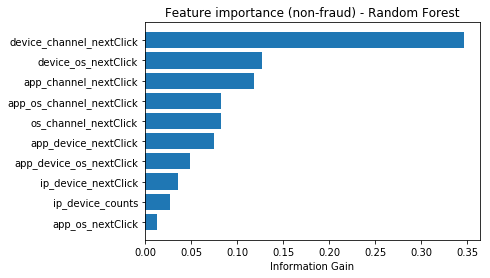

In [27]:
y_pos = np.arange(len(feature_importance_rf.feature[feature_importance_rf.importance>=0.01]))

plt.barh(y_pos, feature_importance_rf.importance[feature_importance_rf.importance>=0.01])
plt.yticks(y_pos, feature_importance_rf.feature[feature_importance_rf.importance>=0.01])
plt.title('Feature importance (non-fraud) - Random Forest')
plt.xlabel('Information Gain')
plt.show()

Similarly to Logistic Regression, for Random Forest the 'next_click' features also seem to be very important in predicting non-fraud. Additionally, some of the 'count' features seem to be influential as well.<br>

In [28]:
feature_importance_rf = feature_importance_rf.sort_values(by='importance', ascending=False)

In [29]:
feature_importance_rf['cum_sum'] = feature_importance_rf['importance'].cumsum()
feature_importance_rf['cum_perc'] = 100*feature_importance_rf['cum_sum']/feature_importance_rf['importance'].sum()
feature_importance_rf

,feature,importance,cum_sum,cum_perc
39,device_channel_nextClick,0.346096,0.346096,34.6096
38,device_os_nextClick,0.127277,0.473373,47.3373
37,app_channel_nextClick,0.118589,0.591962,59.1962
49,app_os_channel_nextClick,0.0824855,0.674448,67.4448
40,os_channel_nextClick,0.0820715,0.756519,75.6519
...,...,...,...,...
54,ip_device_os_channel_nextClick,9.52906e-06,0.999977,99.9977
46,ip_os_channel_nextClick,8.74576e-06,0.999985,99.9985
27,ip_app_os_channel_counts,7.42862e-06,0.999993,99.9993
30,ip_app_device_os_channel_counts,3.62215e-06,0.999996,99.9996


## 3.3) Remove irrelevant features

Based on these findings, I am going to rank the features based on their information gain, calculate the cumulated sum over total information gain, and drop every feature that belongs to the last five percent. In that way, the dataset becomes easier to handle and possible noise is removed.

Drop features that add little to know information gain or have an irrelevant beta factor:

In [30]:
irrelevant_features = [b or a for a, b in zip_longest(feature_importance_rf[feature_importance_rf['cum_perc']>95]['feature'],feature_importance_logit[feature_importance_logit['cum_perc']>95]['feature'])]

In [31]:
counts = Counter(irrelevant_features)
dupids = [x for x in irrelevant_features if counts[x] > 1]

In [32]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

remove_features = dupids
print(Remove(dupids)) 

['ip_app_device_os_channel_nextClick', 'ip_os_channel_nextClick', 'ip_app_device_os_channel_counts', 'ip_device_os_channel_counts', 'ip_app_device_channel_counts', 'ip_app_os_channel_counts', 'ip_os_channel_counts', 'ip_device_channel_counts', 'ip_channel_counts', 'ip_app_channel_counts', 'cos_click_day', 'ip_app_device_os_counts', 'ip_app_os_counts']


In [33]:
X_train = X_train.drop(remove_features, axis = 1)
X_test = X_test.drop(remove_features, axis = 1)

# 4.) Running baseline models plus additional models without hyperparameter tuning after dropping irrelevant features

I have decided to test three different model types:<br>
- Linear model: Logistic Regression
- Ensemble learning (Bagging): Random Forest
- Ensemble learning (Boosting): XGBoost

First, I will run all models without performing parameter tuning to see how well they performe compared to the baseline models (Logistic Regression and Random Forest) that were trained on the whole dataset in '50_EDA_and_Feature_Engineering'.

## 4.1) Logistic Regression

In [34]:
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)

In [35]:
# Train score
logit_y_pred_train = logit.predict(X_train)

# Cross-validation error
logit_cv = cross_val_score(logit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
logit_y_pred_test = logit.predict(X_test)

Using classification report and AUC curve to evaluate performance.<br>

Classification reports:

In [36]:
print('Classification report: Train set\n', classification_report(y_train, logit_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, logit_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(logit_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       0.77      0.83      0.80    319792
       Fraud       0.81      0.75      0.78    319792

    accuracy                           0.79    639584
   macro avg       0.79      0.79      0.79    639584
weighted avg       0.79      0.79      0.79    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       0.77      0.83      0.80    137054
       Fraud       0.81      0.75      0.78    137054

    accuracy                           0.79    274108
   macro avg       0.79      0.79      0.79    274108
weighted avg       0.79      0.79      0.79    274108
 ##########################################################
Avg. f1 score: cross-validation set
 0.78


ROC-AUC curve:

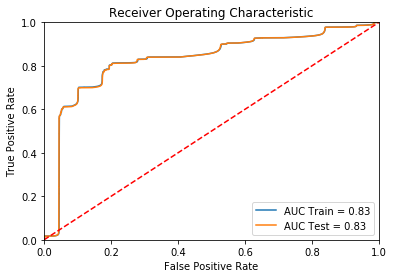

In [37]:
# Train FPR and TPR
logit_probs_train = logit.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, logit_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
logit_probs_test = logit.predict_proba(X_test)
fpr_test_logit, tpr_test_logit, threshold_test = metrics.roc_curve(y_test, logit_probs_test[:,1])
roc_auc_test_logit = metrics.auc(fpr_test_logit, tpr_test_logit)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_logit, tpr_test_logit, label = 'AUC Test = %0.2f' % roc_auc_test_logit)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

## 4.2) Random Forest Classifier

In [38]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

In [39]:
# Train score
rf_y_pred_train = rf.predict(X_train)

# Cross-validation error
rf_cv = cross_val_score(rf, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
rf_y_pred_test = rf.predict(X_test)

Classification reports:

In [40]:
print('Classification report: Train set\n', classification_report(y_train, rf_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, rf_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(rf_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    319792
       Fraud       1.00      1.00      1.00    319792

    accuracy                           1.00    639584
   macro avg       1.00      1.00      1.00    639584
weighted avg       1.00      1.00      1.00    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    137054
       Fraud       1.00      1.00      1.00    137054

    accuracy                           1.00    274108
   macro avg       1.00      1.00      1.00    274108
weighted avg       1.00      1.00      1.00    274108
 ##########################################################
Avg. f1 score: cross-validation set
 1.0


ROC-AUC curve:

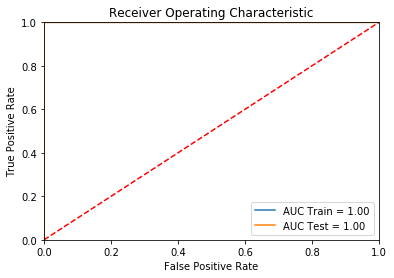

In [41]:
# Train FPR and TPR
rf_probs_train = rf.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, rf_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
rf_probs_test = rf.predict_proba(X_test)
fpr_test_rf, tpr_test_rf, threshold_test = metrics.roc_curve(y_test, rf_probs_test[:,1])
roc_auc_test_rf = metrics.auc(fpr_test_rf, tpr_test_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_rf, tpr_test_rf, label = 'AUC Test = %0.2f' % roc_auc_test_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

## 4.3) XGBoost

In [42]:
xgb = XGBClassifier()
xgb = xgb.fit(X_train, y_train)

In [43]:
# Train score
xgb_y_pred_train = xgb.predict(X_train)

# Cross-validation error
xgb_cv = cross_val_score(xgb, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
xgb_y_pred_test = xgb.predict(X_test)

In [44]:
print('Classification report: Train set\n', classification_report(y_train, xgb_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, xgb_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(xgb_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    319792
       Fraud       1.00      1.00      1.00    319792

    accuracy                           1.00    639584
   macro avg       1.00      1.00      1.00    639584
weighted avg       1.00      1.00      1.00    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    137054
       Fraud       1.00      1.00      1.00    137054

    accuracy                           1.00    274108
   macro avg       1.00      1.00      1.00    274108
weighted avg       1.00      1.00      1.00    274108
 ##########################################################
Avg. f1 score: cross-validation set
 1.0


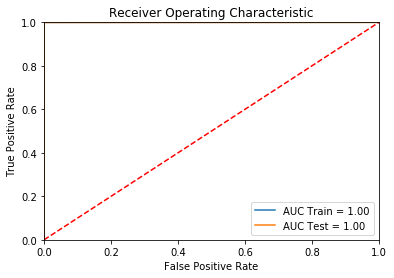

In [45]:
# Train FPR and TPR
xgb_probs_train = xgb.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, xgb_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
xgb_probs_test = xgb.predict_proba(X_test)
fpr_test_xgb, tpr_test_xgb, threshold_test = metrics.roc_curve(y_test, xgb_probs_test[:,1])
roc_auc_test_xgb = metrics.auc(fpr_test_xgb, tpr_test_xgb)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_xgb, tpr_test_xgb, label = 'AUC Test = %0.2f' % roc_auc_test_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

# 5.) Parameter tuning

## 5.1) Tuning Logistic Regression

Using Random GridSearch to approximate C.

In [46]:
C = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]

logit_random_grid = {'C': C}

In [47]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
logit_random = RandomizedSearchCV(estimator = logit, param_distributions = logit_random_grid,
                                  n_iter = 50, cv = 3, verbose=2, n_jobs = -1, scoring = 'f1')
logit_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'C': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                                              20]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=2)

In [48]:
logit_random.best_params_

{'C': 14}

Using C of 10 and comparing l1 regularization (Lasso) versus l2 (Ridge)

### 5.1.1) Lasso Regularization

In [49]:
logit = LogisticRegression(C=10, penalty='l1', solver='saga')
logit = logit.fit(X_train, y_train)

In [50]:
# Train score
logit_y_pred_train = logit.predict(X_train)

# Cross-validation error
logit_cv = cross_val_score(logit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
logit_y_pred_test = logit.predict(X_test)

In [51]:
print('Classification report: Train set\n', classification_report(y_train, logit_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, logit_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(logit_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       0.78      0.82      0.80    319792
       Fraud       0.81      0.77      0.79    319792

    accuracy                           0.80    639584
   macro avg       0.80      0.80      0.80    639584
weighted avg       0.80      0.80      0.80    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       0.78      0.82      0.80    137054
       Fraud       0.81      0.77      0.79    137054

    accuracy                           0.80    274108
   macro avg       0.80      0.80      0.80    274108
weighted avg       0.80      0.80      0.80    274108
 ##########################################################
Avg. f1 score: cross-validation set
 0.79


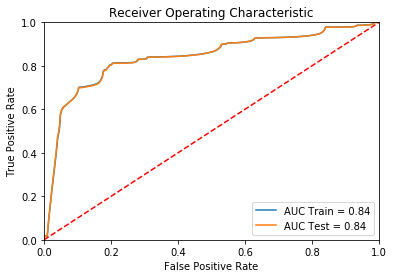

In [52]:
# Train FPR and TPR
logit_probs_train = logit.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, logit_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
logit_probs_test = logit.predict_proba(X_test)
fpr_test_logit, tpr_test_logit, threshold_test = metrics.roc_curve(y_test, logit_probs_test[:,1])
roc_auc_test_logit = metrics.auc(fpr_test_logit, tpr_test_logit)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_logit, tpr_test_logit, label = 'AUC Test = %0.2f' % roc_auc_test_logit)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

### 5.1.2) Ridge Regularization

In [53]:
logit_l2 = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
logit_l2 = logit.fit(X_train, y_train)

In [54]:
# Train score
logit_l2_y_pred_train = logit_l2.predict(X_train)

# Cross-validation error
logit_l2_cv = cross_val_score(logit_l2, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
logit_l2_y_pred_test = logit_l2.predict(X_test)

In [55]:
print('Classification report: Train set\n', classification_report(y_train, logit_l2_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, logit_l2_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(logit_l2_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       0.78      0.82      0.80    319792
       Fraud       0.81      0.77      0.79    319792

    accuracy                           0.80    639584
   macro avg       0.80      0.80      0.80    639584
weighted avg       0.80      0.80      0.80    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       0.78      0.82      0.80    137054
       Fraud       0.81      0.77      0.79    137054

    accuracy                           0.80    274108
   macro avg       0.80      0.80      0.80    274108
weighted avg       0.80      0.80      0.80    274108
 ##########################################################
Avg. f1 score: cross-validation set
 0.79


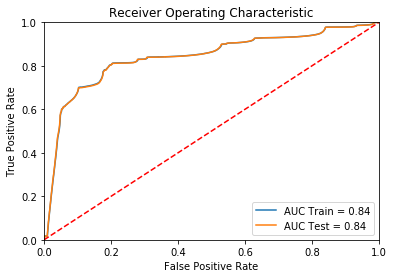

In [56]:
# Train FPR and TPR
logit_l2_probs_train = logit_l2.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, logit_l2_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
logit_l2_probs_test = logit_l2.predict_proba(X_test)
fpr_test_logit_l2, tpr_test_logit_l2, threshold_test = metrics.roc_curve(y_test, logit_l2_probs_test[:,1])
roc_auc_test_logit_l2 = metrics.auc(fpr_test_logit_l2, tpr_test_logit_l2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_logit_l2, tpr_test_logit_l2, label = 'AUC Test = %0.2f' % roc_auc_test_logit_l2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

## 5.2) Tuning Random Forest


In [57]:
# Create the parameter grid based on the results of random search 
param_grid = {'max_depth': [2, 5, 10], # From the feature importance, we can see that mainly 10 features are accounting for almost all information gain
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300]}

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 145.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [63]:

# Train score
rf_y_pred_train_grid = rf_grid.predict(X_train)

# Cross-validation error
#rf_cv_grid = cross_val_score(rf_grid, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1)

# Test score
rf_y_pred_test_grid = rf_grid.predict(X_test)

In [64]:
print('Classification report: Train set\n', classification_report(y_train, rf_y_pred_train_grid, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, rf_y_pred_test_grid, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(rf_cv_grid.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    319792
       Fraud       1.00      1.00      1.00    319792

    accuracy                           1.00    639584
   macro avg       1.00      1.00      1.00    639584
weighted avg       1.00      1.00      1.00    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    137054
       Fraud       1.00      1.00      1.00    137054

    accuracy                           1.00    274108
   macro avg       1.00      1.00      1.00    274108
weighted avg       1.00      1.00      1.00    274108
 ##########################################################


NameError: name 'rf_cv_grid' is not defined

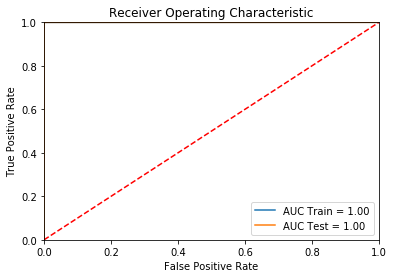

In [65]:
# Train FPR and TPR
rf_probs_train = rf_grid.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, rf_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
rf_probs_test = rf_grid.predict_proba(X_test)
fpr_test_rf, tpr_test_rf, threshold_test = metrics.roc_curve(y_test, rf_probs_test[:,1])
roc_auc_test_rf = metrics.auc(fpr_test_rf, tpr_test_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_rf, tpr_test_rf, label = 'AUC Test = %0.2f' % roc_auc_test_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

## 5.3) Tuning XGBoost

In [68]:
# Create the parameter grid based on the results of random search 
param_grid = {'eta': [0.01,0.1,0.2], # From the feature importance, we can see that mainly 10 features are accounting for almost all information gain
              'max_depth': [2, 5, 10],
              'min_child_weight': [2, 4]}

# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1')
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 33.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'eta': [0.01, 0.1, 0.2], 'max_depth': [2, 5, 10],
                         'min_child_weight': [2, 4]},
             pre_dispatch='2*n_jobs', re

In [144]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [70]:
# Train score
xgb_y_pred_train = xgb_grid.predict(X_train)

# Cross-validation error
#xgb_cv = cross_val_score(xgb_grid, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 2)

# Test score
xgb_y_pred_test = xgb_grid.predict(X_test)

In [71]:
print('Classification report: Train set\n', classification_report(y_train, xgb_y_pred_train, target_names=['No Fraud','Fraud']),
     '##########################################################')
print('Classification report: Test set\n', classification_report(y_test, xgb_y_pred_test, target_names=['No Fraud','Fraud']),
      '##########################################################')
print('Avg. f1 score: cross-validation set\n', round(xgb_cv.mean(), 2))

Classification report: Train set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    319792
       Fraud       1.00      1.00      1.00    319792

    accuracy                           1.00    639584
   macro avg       1.00      1.00      1.00    639584
weighted avg       1.00      1.00      1.00    639584
 ##########################################################
Classification report: Test set
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    137054
       Fraud       1.00      1.00      1.00    137054

    accuracy                           1.00    274108
   macro avg       1.00      1.00      1.00    274108
weighted avg       1.00      1.00      1.00    274108
 ##########################################################
Avg. f1 score: cross-validation set
 1.0


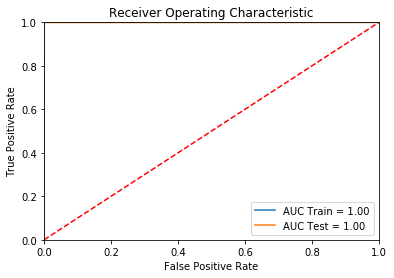

In [72]:
# Train FPR and TPR
xgb_probs_train = xgb_grid.predict_proba(X_train)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, xgb_probs_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Test FPR and TPR
xgb_probs_test = xgb.predict_proba(X_test)
fpr_test_xgb, tpr_test_xgb, threshold_test = metrics.roc_curve(y_test, xgb_probs_test[:,1])
roc_auc_test_xgb = metrics.auc(fpr_test_xgb, tpr_test_xgb)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test_xgb, tpr_test_xgb, label = 'AUC Test = %0.2f' % roc_auc_test_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

del fpr_train, tpr_train, threshold_train, threshold_test, roc_auc_train

# 6.) Finding optimal threshold to make predictions more generalizable

Because we previously have under-sampled the dataset, the models are trained on way more actual download data than we would expect in a real-world setting. Therefore, we need to account for this. One option to do so is by increasing the threshold of 0.5. This might decrease the, previously perfect, accurracy, but will make the model more generalizable for the hold-out set.<br>

Taking probabilities previously calculated.

In [73]:
def threshold_metrices(model_probs, threshold_probs, y_true):
    threshold = []
    accuracy = []
    f1 = []
    recall = []
    precision = []
    for i in threshold_probs:
        threshold.append(i)
        y_pred = [1 if x>i else 0 for x in model_probs[:,1]]
        accuracy.append(accuracy_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))
        precision.append(precision_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))
    d = {'threshold': threshold, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}
    threshold_metrices_df = pd.DataFrame(d)
    return threshold_metrices_df

## 6.1) Logistic Regression

Looking at the distribution of predicted probabilities first:

Text(0, 0.5, 'Frequency')

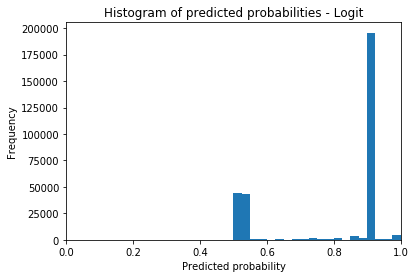

In [74]:
plt.hist(logit_probs_train[logit_probs_train[:,1]>0.5][:,1], bins=20)

plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - Logit')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

It seems like most of the predictions have a probability of 0.9 or higher, while there are still some predictions that might be ambigious.<br>

In [75]:
threshold_probas = np.linspace(start = 0.05, stop = 0.95, num = 18)

logit_metr_thre_train = threshold_metrices(logit_probs_train, threshold_probas, y_train)

In [76]:
logit_metr_thre_train

,accuracy,f1,precision,recall,threshold
0,0.502558,0.667747,0.501283,0.999737,0.050000
1,0.567334,0.693325,0.536963,0.978161,0.102941
2,0.636772,0.718994,0.586281,0.929370,0.155882
3,0.648751,0.725174,0.595589,0.926827,0.208824
4,0.683086,0.739559,0.627704,0.899922,0.261765
5,0.765182,0.781487,0.730745,0.839802,0.314706
6,0.803611,0.805095,0.799058,0.811224,0.367647
7,0.803610,0.803740,0.803208,0.804273,0.420588
8,0.798916,0.795519,0.809190,0.782302,0.473529
9,0.798078,0.776477,0.869495,0.701437,0.526471


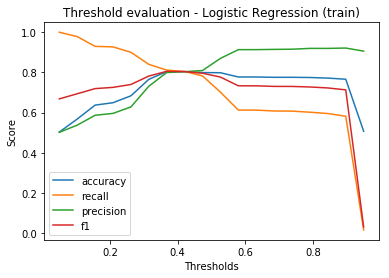

In [77]:
plt.plot(logit_metr_thre_train.threshold, logit_metr_thre_train.accuracy)
plt.plot(logit_metr_thre_train.threshold, logit_metr_thre_train.recall)
plt.plot(logit_metr_thre_train.threshold, logit_metr_thre_train.precision)
plt.plot(logit_metr_thre_train.threshold, logit_metr_thre_train.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - Logistic Regression (train)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

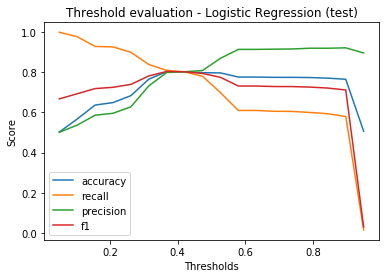

In [78]:
logit_metr_thre_test = threshold_metrices(logit_probs_test, threshold_probas, y_test)

plt.plot(logit_metr_thre_test.threshold, logit_metr_thre_test.accuracy)
plt.plot(logit_metr_thre_test.threshold, logit_metr_thre_test.recall)
plt.plot(logit_metr_thre_test.threshold, logit_metr_thre_test.precision)
plt.plot(logit_metr_thre_test.threshold, logit_metr_thre_test.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - Logistic Regression (test)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

## 6.2) Random Forest

Text(0, 0.5, 'Frequency')

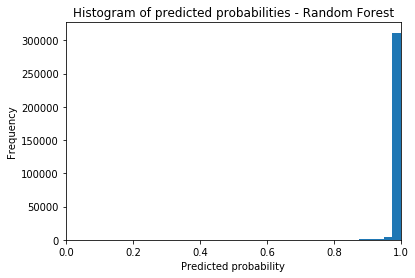

In [79]:
plt.hist(rf_probs_train[rf_probs_train[:,1]>0.5][:,1], bins=20)

plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - Random Forest')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

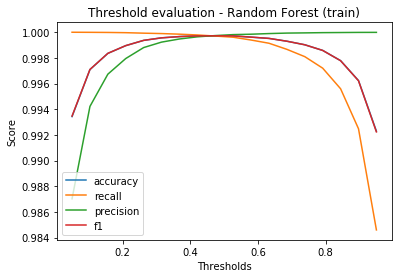

In [80]:
rf_metr_thre_train = threshold_metrices(rf_probs_train, threshold_probas, y_train)

plt.plot(rf_metr_thre_train.threshold, rf_metr_thre_train.accuracy)
plt.plot(rf_metr_thre_train.threshold, rf_metr_thre_train.recall)
plt.plot(rf_metr_thre_train.threshold, rf_metr_thre_train.precision)
plt.plot(rf_metr_thre_train.threshold, rf_metr_thre_train.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - Random Forest (train)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

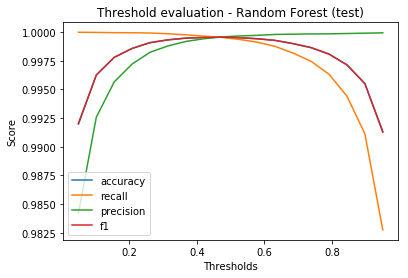

In [81]:
rf_metr_thre_test = threshold_metrices(rf_probs_test, threshold_probas, y_test)

plt.plot(rf_metr_thre_test.threshold, rf_metr_thre_test.accuracy)
plt.plot(rf_metr_thre_test.threshold, rf_metr_thre_test.recall)
plt.plot(rf_metr_thre_test.threshold, rf_metr_thre_test.precision)
plt.plot(rf_metr_thre_test.threshold, rf_metr_thre_test.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - Random Forest (test)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

## 6.3) XGBoost


Text(0, 0.5, 'Frequency')

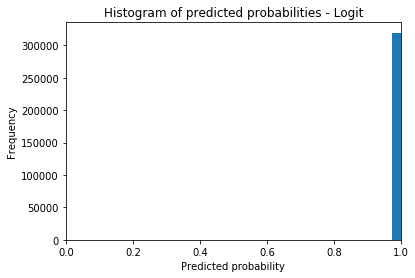

In [82]:
plt.hist(xgb_probs_train[xgb_probs_train[:,1]>0.5][:,1], bins=20)

plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - Logit')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

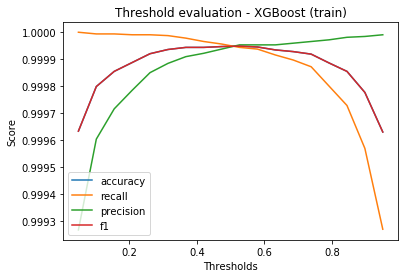

In [83]:
xgb_metr_thre_train = threshold_metrices(xgb_probs_train, threshold_probas, y_train)

plt.plot(xgb_metr_thre_train.threshold, xgb_metr_thre_train.accuracy)
plt.plot(xgb_metr_thre_train.threshold, xgb_metr_thre_train.recall)
plt.plot(xgb_metr_thre_train.threshold, xgb_metr_thre_train.precision)
plt.plot(xgb_metr_thre_train.threshold, xgb_metr_thre_train.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - XGBoost (train)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

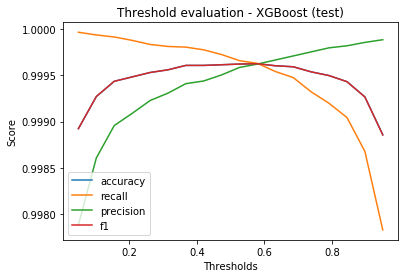

In [84]:
xgb_metr_thre_test = threshold_metrices(xgb_probs_test, threshold_probas, y_test)

plt.plot(xgb_metr_thre_test.threshold, xgb_metr_thre_test.accuracy)
plt.plot(xgb_metr_thre_test.threshold, xgb_metr_thre_test.recall)
plt.plot(xgb_metr_thre_test.threshold, xgb_metr_thre_test.precision)
plt.plot(xgb_metr_thre_test.threshold, xgb_metr_thre_test.f1)
plt.legend(['accuracy', 'recall', 'precision', 'f1'], loc='lower left')
plt.title('Threshold evaluation - XGBoost (test)')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.show()

# 7.) Apply final model to test set

In [99]:
from sklearn.preprocessing import StandardScaler

In [124]:
# If running on the test set, make sure to separate out "click_id"
def FeatureEngineer(df):
    #Split out the clicktime
    df.click_time = pd.to_datetime(df.click_time)
    df['day'] = df['click_time'].dt.dayofweek.astype('uint8')
    df['hour'] = df['click_time'].dt.hour.astype('uint8')
    df['minute'] = df['click_time'].dt.minute.astype('uint8')
    df['second'] = df['click_time'].dt.second.astype('uint8')
        
    df['click_rnd']=df['click_time'].dt.round('H')  
    
    # Build the double combos
    cols = df.columns[:5]
    for i in np.arange(0,4):
        for j in np.arange(i+1,5):
                df[str(cols[i]+'_'+cols[j])] = df[cols[i]].map(str)+'_'+df[cols[j]].map(str)

    # Build the double combo counts
    for col in df.columns[-10:]:
        df = df.join(df[col].value_counts(), on=col, how='left', rsuffix='_counts')

    # Drop the combo columns now that we have the counts
    cols_drop = df.columns[-20:-10].values
    df = df.drop(cols_drop, axis=1)

    # Build the triple combination columns
    cols = df.columns[:5]
    for i in np.arange(0,3):
        for j in np.arange(i+1,4):
            for k in np.arange(j+1,5):
                df[str(cols[i]+'_'+cols[j]+'_'+cols[k])] = (
                        df[cols[i]].map(str)+'_'+df[cols[j]].map(str)+'_'+df[cols[k]].map(str))

    # Build the triple combo counts
    for col in df.columns[-10:]:
        df = df.join(df[col].value_counts(), on=col, how='left', rsuffix='_counts')

    # Drop the combo columns now that we have the counts
    cols_drop = df.columns[-20:-10].values
    df = df.drop(cols_drop, axis=1)

    # Build the quadruple combos
    for i in np.arange(0,2):
        for j in np.arange(i+1,3):
            for k in np.arange(j+1,4):
                for l in np.arange(k+1,5):
                    df[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_'+cols[l])] = (
                        df[cols[i]].map(str)+'_'+df[cols[j]].map(str)+'_'+df[cols[k]].map(str)+'_'+df[cols[l]].map(str))

    # Build the 5-combo column:
    df[str(cols[0]+'_'+cols[1]+'_'+cols[2]+'_'+cols[3]+'_'+cols[4])] = (
                        df[cols[0]].map(str)+'_'+df[cols[1]].map(str)+'_'+df[cols[2]].map(str)+'_'+df[cols[3]].map(str)+'_'+df[cols[4]].map(str))

    # Build the quadruple and 5-combo counts
    for col in df.columns[-6:]:
        df = df.join(df[col].value_counts(), on=col, how='left', rsuffix='_counts')

    # Drop the combo columns now that we have the counts
    cols_drop = df.columns[-12:-6].values
    df = df.drop(cols_drop, axis=1)
    
    scaler = StandardScaler()
    df.iloc[:,-26:] = scaler.fit_transform(df.iloc[:,-26:])
    
    # Build the double combos
    cols = df.columns[:5]
    for i in np.arange(0,4):
        for j in np.arange(i+1,5):
                df[str(cols[i]+'_'+cols[j]+'_nextClick')] = (
                    df.groupby([cols[i], cols[j]]).click_time.shift(-1) - df.click_time).dt.seconds.astype(np.float32)

    # Build the triple combination columns
    cols = df.columns[:5]
    for i in np.arange(0,3):
        for j in np.arange(i+1,4):
            for k in np.arange(j+1,5):
                df[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_nextClick')] = (
                        df.groupby([cols[i], cols[j], cols[k]]).click_time.shift(-1) - df.click_time).dt.seconds.astype(np.float32)

    # Build the quadruple combos
    for i in np.arange(0,2):
        for j in np.arange(i+1,3):
            for k in np.arange(j+1,4):
                for l in np.arange(k+1,5):
                    df[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_'+cols[l]+'_nextClick')] = (
                        df.groupby([cols[i], cols[j], cols[k], cols[l]]).click_time.shift(-1) - df.click_time).dt.seconds.astype(np.float32)        


    # Build the 5-combo column:
    df[str(cols[0]+'_'+cols[1]+'_'+cols[2]+'_'+cols[3]+'_'+cols[4]+'_nextClick')] = (
         df.groupby([cols[0], cols[1], cols[2], cols[3], cols[4]]).click_time.shift(-1) - df.click_time).dt.seconds.astype(np.float32)

    #Fill NAs with large value 1e10
    df = df.fillna(1e10)

    # Creating click_hour variable
    df['click_hour'] = df.click_rnd.dt.hour
    df['click_day'] = df.click_rnd.dt.day

    # Dropping click_time and click_rnd
    df= df.drop(['click_time','click_rnd'], axis=1)

    # Cyclical by hour

    hours_in_day = 24

    df['sin_click_hour'] = np.sin(2*np.pi*df.click_hour/hours_in_day)
    df['cos_click_hour'] = np.cos(2*np.pi*df.click_hour/hours_in_day)

    df= df.drop(['click_hour'], axis=1)

    # Cyclical by day

    days_in_week = 7

    df['sin_click_day'] = np.sin(2*np.pi*df.click_day/days_in_week)
    df['cos_click_day'] = np.cos(2*np.pi*df.click_day/days_in_week)

    df = df.drop(['click_day'], axis=1)
    
    # Set variables as categorical
    variables = ['ip', 'app', 'device', 'os', 'channel']
    for v in variables:
        df[v] = df[v].astype('category')

    del hours_in_day, days_in_week
    
    return df


## Reading in the test set from Kaggle competition

In [129]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        #'is_attributed' : 'uint8',
        #'click_id'      : 'uint32',
        }

keep_cols = ['ip','app','device','os','channel','click_time']

data2 = pd.read_csv('test.csv', usecols = keep_cols)#, dtype = dtypes)

In [130]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 6 columns):
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_time    object
dtypes: int64(5), object(1)
memory usage: 860.2+ MB


## Applying the feature engineering

In [131]:
data2 = FeatureEngineer(data2)

In [132]:
data2 = data2.drop(['day','hour','minute','second'], axis = 1)
data2 = data2.drop(remove_features, axis = 1)

In [133]:
data2['ip'] = data2['ip'].astype('uint32')
data2['app'] = data2['app'].astype('uint16')
data2['device'] = data2['device'].astype('uint16')
data2['os'] = data2['os'].astype('uint16')
data2['channel'] = data2['channel'].astype('uint16')

## Making sure the shape and dtypes match our X_train

In [134]:
X_train.shape

(639584, 48)

In [135]:
data2.shape

(18790469, 48)

In [136]:
X_train.dtypes == data2.dtypes

ip                                 True
app                                True
device                             True
os                                 True
channel                            True
ip_app_counts                      True
ip_device_counts                   True
ip_os_counts                       True
app_device_counts                  True
app_os_counts                      True
app_channel_counts                 True
device_os_counts                   True
device_channel_counts              True
os_channel_counts                  True
ip_app_device_counts               True
ip_device_os_counts                True
app_device_os_counts               True
app_device_channel_counts          True
app_os_channel_counts              True
device_os_channel_counts           True
app_device_os_channel_counts       True
ip_app_nextClick                   True
ip_device_nextClick                True
ip_os_nextClick                    True
ip_channel_nextClick               True


## Making final predictions using our best model

In [137]:
xgb_y_pred_final = xgb_grid.predict(data2)

In [ ]:
# with open('xgb_y_pred_final.pkl','wb') as f:
#     pickle.dump(xgb_y_pred_final, f)

# with open('test.pkl','rb') as f:
#     x = pickle.load(f)
#     print(x.shape)

In [141]:
len(data2), len(xgb_y_pred_final)

(18790469, 18790469)

In [138]:
submission = pd.DataFrame({'click_id':pd.Series(list(range(len(xgb_y_pred_final)))), 'is_attributed':xgb_y_pred_final})

In [139]:
submission.head()

,click_id,is_attributed
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [140]:
submission.to_csv('xgb_sub.csv', float_format='%.8f', index=False)